# Homework 7: Correlation, Regression, and Least Squares

Please complete this notebook by filling in the cells provided. 

Reading:
- Textbook chapter [12](https://www.inferentialthinking.com/chapters/12/why-the-mean-matters.html) (for review)
- Textbook chapter [13](https://www.inferentialthinking.com/chapters/13/prediction.html)

Run the cell below to prepare the notebook.

In [1]:
# Run this cell to set up the notebook, but please don't change it.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)
from matplotlib import patches
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

# Don't change this cell; just run it. 
from client.api.notebook import Notebook
ok = Notebook('hw07.ok')
#ok.auth(inline=True)

Assignment: Homework 7: Correlation, Regression, and Least Squares
OK, version v1.14.15



When you are finished, run the following cell to submit your work.

In [ ]:
ok.submit();

## 1. Evaluating NBA Game Predictions


#### A brief introduction to sports betting
In a basketball game, each team scores some number of points.  Conventionally, the team playing at its own arena is called the "home team," and the other team is called the "away team."  The winner is the team with the most points.

We can summarize what happened in a game by the "**outcome**", defined as the **the away team's score minus the home team's score**:

$$\text{outcome} = \text{points scored by the away team} - \text{points scored by the home team}$$

If this number is positive, the away team won.  If it's negative, the home team won. 

Casinos in Las Vegas offer bets on the outcomes of NBA games.  One kind of bet works like this:

1. The casino decides on a "spread."
2. You can bet \$11 that the outcome will be above the spread, or \$11 that the outcome will be below the spread.
3. After the game, you end up with \$ 1 if you guessed correctly, and \$ 0 if you guessed incorrectly.

The analysts at the casino try to choose the spread so that (according to their analysis of the teams) there is a 50% chance that the outcome will be below that amount, and a 50% chance that the outcome will be above that amount.

**[tl;dr](https://en.wikipedia.org/wiki/Wikipedia:Too_long;_didn%27t_read): The spread is the casino's best guess at the outcome (the away team's score minus the home team's score).**

The table `spreads` contains spreads from the betting website [Covers](http://www.covers.com) from every game in the 2014 NBA season, plus actual game outcomes.  

In [2]:
spreads = Table.read_table("spreads.csv")
spreads

Date,Home Team,Away Team,Home Points,Away Points,Outcome,Spread
4/10/2015,Utah,Memphis,88,89,1,2.5
3/10/2015,Utah,New York,87,82,-5,-13
11/19/2014,Indiana,Charlotte,88,86,-2,-2
11/15/2014,Chicago,Indiana,90,99,9,-9
3/25/2015,Utah,Portland,89,92,3,-2
3/3/2015,Memphis,Utah,82,93,11,-7
3/18/2015,Utah,Washington,84,88,4,-3
3/16/2015,Utah,Charlotte,94,66,-28,-4.5
1/24/2015,Charlotte,New York,76,71,-5,-9
11/7/2014,Oklahoma City,Memphis,89,91,2,7


Here's a scatter plot of the outcomes and spreads, with the spreads on the horizontal axis.

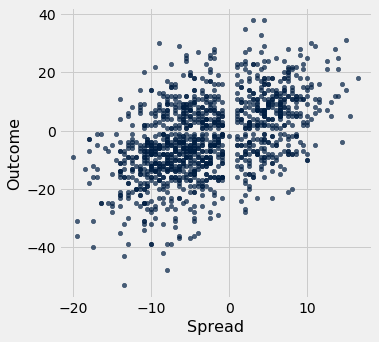

In [3]:
spreads.scatter("Spread", "Outcome")

#### Question 1
Why do you think that the spread and outcome are never 0 (aside from 1 case of the spread being 0)? 

If it was zero then that would mean that the game ended in a tie and normally regluation rules tell us that a game cannot end in a tie and goes into overtime if there is one at the end of regulation time.

Let's investigate how well the casinos are predicting game outcomes.

One question we can ask is: Is the casino's prediction correct on average? In other words, for every value of the spread, is the average outcome of games assigned that spread equal to the spread? If not, the casino would apparently be making a systematic error in its predictions.

#### Question 2
Among games with a spread around 5, from 3.5 to 6.5 (including both 3.5 and 6.5), what was the average outcome? 

*Hint:* Read the [documentation for the predicate `are.between_or_equal_to`](http://data8.org/datascience/predicates.html#datascience.predicates.are.between_or_equal_to).

In [4]:
spreads_around_5 = spreads.where('Spread', are.between_or_equal_to(3.5, 6.5))
spread_5_outcome_average = np.mean(spreads_around_5.column('Spread'))
print("Average outcome for spreads around 5:", spread_5_outcome_average)

Average outcome for spreads around 5: 4.955882352941177


In [5]:
_ = ok.grade('q1_2')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 3
If the average outcome for games with any given spread turned out to be exactly equal to that spread, what would the slope and intercept of the linear regression line be, in original units?

In [6]:
expected_slope_for_equal_spread = 1
expected_intercept_for_equal_spread = 0

#r = np.mean((faithful_standard.column("duration (standard units)"))*(faithful_standard.column("wait (standard units)")))

#slope = r * (wait_std/duration_std)

#intercept = slope*(-duration_mean) + wait_mean

In [7]:
_ = ok.grade('q1_3')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 4
Fix the `standard_units` function below.  It should take an array of numbers as its argument and return an array of those numbers in standard units.

In [8]:
def standard_units(nums):
    """Return an array where every value in nums is converted to standard units."""
    return (nums - np.mean(nums)) / np.std(nums)
nms = [2,0,3,6,4]
standard_units(nms)

array([-0.5, -1.5,  0. ,  1.5,  0.5])

In [9]:
_ = ok.grade('q1_4')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 5
Compute the correlation between outcomes and spreads.

In [10]:
spread_std = np.std(spreads.column("Spread"))
outcome_std = np.std(spreads.column("Outcome"))

spread_r = np.mean((standard_units(spreads.column("Spread")))*(standard_units(spreads.column("Outcome"))))
spread_r

0.49181413688314235

In [11]:
_ = ok.grade('q1_5')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 6
Compute the slope of the least-squares linear regression line that predicts outcomes from spreads, in original units.

In [12]:
spread_slope = spread_r * (outcome_std/spread_std) #slope y/x
spread_slope

0.9539269682264327

In [13]:
_ = ok.grade('q1_6')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 7
For the "best fit" line that estimates the average outcome from the spread, the slope is less than 1. Is it `True` or `False` that this fact alone tells you whether the average spread was higher than the average outcome? If you think you need more information than just the slope of the regression line to answer that question, then respond `False`. Briefly justify your answer below.

In [14]:
slope_implies_average_spread_above_average_outcome = True

You can tell that the average spread is above average outcome becasue if it were the other way around our slope would be more than 1. 

In [15]:
_ = ok.grade('q1_7')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



## 2. Finding the Least Squares Regression Line


In this exercise, you'll work with a small invented data set.  Run the next cell to generate the dataset `d` and see a scatter plot.

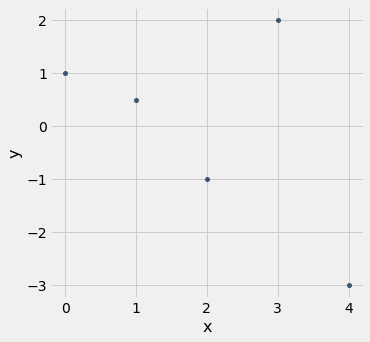

In [16]:
d = Table().with_columns(
    'x', make_array(0,  1,  2,  3,  4),
    'y', make_array(1, .5, -1,  2, -3))
d.scatter('x')


#### Question 1 (Ungraded, but you'll need the result later)
Running the cell below will generate sliders that control the slope and intercept of a line through the scatter plot.  When you adjust a slider, the line will move.

By moving the line around, make your best guess at the least-squares regression line.  (It's okay if your line isn't exactly right, as long as it's reasonable.)

**Note:** Python will probably take about a second to redraw the plot each time you adjust the slider.  We suggest clicking the place on the slider you want to try and waiting for the plot to be drawn; dragging the slider handle around will cause a long lag.

In [17]:
def plot_line(slope, intercept):
    plt.figure(figsize=(5,5))
    
    endpoints = make_array(-2, 7)
    p = plt.plot(endpoints, slope*endpoints + intercept, color='orange', label='Proposed line')
    
    plt.scatter(d.column('x'), d.column('y'), color='blue', label='Points')
    
    plt.xlim(-4, 8)
    plt.ylim(-6, 6)
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.legend(bbox_to_anchor=(1.8, .8))

interact(plot_line, slope=widgets.FloatSlider(min=-4, max=4, step=.1), intercept=widgets.FloatSlider(min=-4, max=4, step=.1));

interactive(children=(FloatSlider(value=0.0, description='slope', max=4.0, min=-4.0), FloatSlider(value=0.0, d…

<div class="hide">\pagebreak</div>

You can probably find a reasonable-looking line by just eyeballing it.  But remember: the least-squares regression line minimizes the mean of the squared errors made by the line for each point.  Your eye might not be able to judge squared errors very well.

#### A note on mean and total squared error
Before we move on, a note is in order.

It is common to think of the least-squares line as the line with the least *mean* squared error (or the square root of the mean squared error), as the textbook does.

But it turns out that it doesn't matter whether you minimize the mean squared error or the *total* squared error.  You'll get the same best line in either case.

That's because the total squared error is just the mean squared error multipled by the number of points (`d.num_rows`).  So if one line gets a better total squared error than another line, then it also gets a better mean squared error.  In particular, the line with the smallest total squared error is also better than every other line in terms of mean squared error.  That makes it the least squares line.

#### Question 2 (Ungraded, but you'll need the result later)
The next cell produces a more useful plot.  Use it to find a line that's closer to the least-squares regression line, keeping the above note in mind.

In [18]:
def plot_line_and_errors(slope, intercept):
    plt.figure(figsize=(5,5))
    points = make_array(-2, 7)
    p = plt.plot(points, slope*points + intercept, color='orange', label='Proposed line')
    ax = p[0].axes
    
    predicted_ys = slope*d.column('x') + intercept
    diffs = predicted_ys - d.column('y')
    for i in np.arange(d.num_rows):
        x = d.column('x').item(i)
        y = d.column('y').item(i)
        diff = diffs.item(i)
        
        if diff > 0:
            bottom_left_x = x
            bottom_left_y = y
        else:
            bottom_left_x = x + diff
            bottom_left_y = y + diff
        
        ax.add_patch(patches.Rectangle(make_array(bottom_left_x, bottom_left_y), abs(diff), abs(diff), color='red', alpha=.3, label=('Squared error' if i == 0 else None)))
        plt.plot(make_array(x, x), make_array(y, y + diff), color='red', alpha=.6, label=('Error' if i == 0 else None))
    
    plt.scatter(d.column('x'), d.column('y'), color='blue', label='Points')
    
    plt.xlim(-4, 8)
    plt.ylim(-6, 6)
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.legend(bbox_to_anchor=(1.8, .8))

interact(plot_line_and_errors, slope=widgets.FloatSlider(min=-4, max=4, step=.1), intercept=widgets.FloatSlider(min=-4, max=4, step=.1));

interactive(children=(FloatSlider(value=0.0, description='slope', max=4.0, min=-4.0), FloatSlider(value=0.0, d…

#### Question 3
Describe the visual criterion you used to find a line in question 2.  (For example, a possible (but incorrect) answer is, "I tried to make the red line for the bottom-right point as small as possible.")

I tried to minimize the oulier point's box size by lining up the other points which were closer together.

#### Question 4
We can say that a point influences the line by how much the line would move if the point were removed from the data set. Does the point at (3, 2) have more or less influence than any other point on the location of the line? 

That point would have more of an influence than others becasue it is a larger error or 'outlier' point than others so it would make a greater difference than the points closest to it.

Now, let's have Python find this line for us.  When we use `minimize`, Python goes through a process similar to the one you might have used in question 2.

But Python can't look at a plot that displays errors!  Instead, we tell it how to find the total squared error for a line with a given slope and intercept.

#### Question 5
Define a function called `total_squared_error`.  It should take two numbers as arguments:

1. the slope of some potential line
2. the intercept of some potential line

It should return the total squared error when we use that line to make predictions for the dataset `d`.

In [19]:
def total_squared_error(slope, intercept):
    # Hint: The staff answer computed an array called predictions
    # and an array called errors first.
    x = d.column(0)
    y = d.column(1)
    predictions = slope*x +intercept
    errors = y-predictions ##space between points
    line = sum(errors**2)
    return line

In [20]:
_ = ok.grade('q2_5')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 6
What is the total squared error for the line you found by "eyeballing" the errors in Question 1?  What about Question 2, where you made a guess that was "aided" by a visualization of the squared error?  (It's okay if the error went up, but for many students, the error will go down when using the visual aid.)

In [21]:
eyeballed_error = total_squared_error(-1.10, 2.4)
aided_error = total_squared_error(-1.10, 2.00)
print("Eyeballed error:", eyeballed_error, "\nAided error:", aided_error)

Eyeballed error: 13.45 
Aided error: 13.05


In [22]:
_ = ok.grade('q2_6')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 7
Use `minimize` to find the actual slope and intercept of the least-squares regression line.

**Note:** `minimize` will return a single array containing the slope as the first element and intercept as the second.

In [23]:
# The staff solution used 1 line of code above here.
mini = minimize(total_squared_error)
slope_from_minimize = mini[0]
intercept_from_minimize = mini[1]
print("Least-squares regression line: predicted_y =",
      slope_from_minimize,
      "* x + ",
      intercept_from_minimize)

Least-squares regression line: predicted_y = -0.6498374231570391 * x +  1.1988619620992735


In [24]:
_ = ok.grade('q2_7')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 8
What was the total squared error for that line?

In [25]:
best_total_squared_error = total_squared_error(-0.6498374231570391,1.1988619620992735)
best_total_squared_error

10.975003568216033

In [26]:
_ = ok.grade('q2_8')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Finally, run the following cell to plot this "best fit" line and its errors:

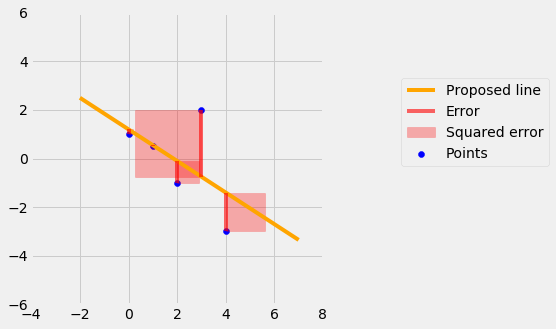

In [27]:
plot_line_and_errors(slope_from_minimize, intercept_from_minimize)

## 3. Triple Jump Distances vs. Vertical Jump Heights


Does skill in one sport imply skill in a related sport?  The answer might be different for different activities.  Let us find out whether it's true for the [triple jump](https://en.wikipedia.org/wiki/Triple_jump) (an horizontal jump similar to a long jump) and the vertical jump.  Since we're learning about linear regression, we will look specifically for a *linear* association between skill in the two sports.

The following data was collected by observing 40 collegiate level soccer players.  Each athlete's distance in both jump activities was measured in centimeters. Run the cell below to load the data.

In [28]:
# Run this cell to load the data
jumps = Table.read_table('triple_vertical.csv')
jumps

triple,vertical
383,33
781,71.1
561.62,62.25
624.52,61.33
446.24,40.19
515.3,38.96
449.22,39.69
560.91,46.51
519.12,37.68
595.38,53.48


#### Question 1
Before running a regression, it's important to see what the data look like, because our eyes are good at picking out unusual patterns in data.  Draw a scatter plot with the triple jump distances on the horizontal axis and the vertical jump heights on vertical axis **that also shows the regression line**. 

See the [documentation for `scatter`](http://data8.org/datascience/_autosummary/datascience.tables.Table.scatter.html#datascience.tables.Table.scatter) for instructions on how to have Python draw the regression line automatically.

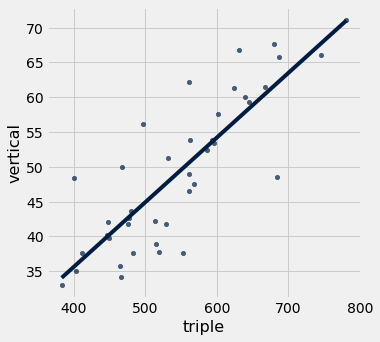

In [29]:
jumps.scatter('triple', 'vertical', fit_line = True)

**Question 2** Does the correlation coefficient `r` look closer to 0, .5, or -.5? Explain. 

I would say closer to 0.5 becasue the data is a little more spread out than it would be if it were closer to 1.

#### Question 3
Create a function called `regression_parameters`. It takes as its argument a table with two columns.  The first column is the x-axis, and the second column is the y-axis.  It should compute the correlation between the two columns, then compute the slope and intercept of the regression line that predicts the second column from the first, in original units (centimeters).  It should return an array with three elements: the correlation coefficient of the two columns, the slope of the regression line, and the intercept of the regression line.

In [48]:
def regression_parameters(t):
    x = t[0]
    y = t[1]
    x_std = (x - np.mean(x)) / np.std(x)
    y_std = (y - np.mean(y)) / np.std(y)
    # Our solution had 4 lines above this one
    r = np.mean((x_std)*(y_std))
    slope = r * np.std(y)/np.std(x)
    intercept = np.mean(y)-slope*np.mean(x)
    return make_array(r, slope, intercept)

# When your function is finished, the next lines should
# compute the regression line predicting vertical jump 
# distances from triple jump distances.
parameters = regression_parameters(jumps)
print('r:', parameters.item(0), '; slope:', parameters.item(1), '; intercept:', parameters.item(2))

r: 0.8343076972837598 ; slope: 0.09295728160512184 ; intercept: -1.566520972963474


In [49]:
_ = ok.grade('q3_3')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 4
Let's use `regression_parameters` to predict what certain athletes' vertical jump heights would be given their triple jump distances.

The world record for the triple jump distance is 18.29 *meters* by Johnathan Edwards. What's our prediction for what Edwards' vertical jump would be?

In [52]:
triple_record_vert_est = (parameters.item(1)*1829) + parameters.item(2)
print("Predicted vertical jump distance: {:f} centimeters".format(triple_record_vert_est))

Predicted vertical jump distance: 168.452347 centimeters


In [53]:
_ = ok.grade('q3_4')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 5
Do you expect this estimate to be accurate within a few centimeters? Why or why not?

*Write your answer here, replacing this text.*

## 4. The Bootstrap and The Normal Curve


In this exercise, we will explore a dataset that includes the safety inspection scores for restauraunts in the city of Austin, Texas.  We will be interested in determining the average restaurant score (out of 100) for the city from a random sample of the scores.  We'll compare two methods for computing a confidence interval for that quantity: the bootstrap resampling method, and an approximation based on the Central Limit Theorem.

In [54]:
# Just run this cell.
pop_restaurants = Table.read_table('restaurant_inspection_scores.csv').drop(5,6)
pop_restaurants

Restaurant Name,Zip Code,Inspection Date,Score,Address
6M Grocery,78652,01/17/2014,90,"805 W FM 1626 RD AUSTIN, TX 78652"
6M Grocery,78652,04/27/2015,93,"805 W FM 1626 RD AUSTIN, TX 78652"
6M Grocery,78652,05/02/2016,88,"805 W FM 1626 RD AUSTIN, TX 78652"
6M Grocery,78652,07/25/2014,100,"805 W FM 1626 RD AUSTIN, TX 78652"
6M Grocery,78652,10/21/2015,87,"805 W FM 1626 RD AUSTIN, TX 78652"
6M Grocery,78652,12/15/2014,93,"805 W FM 1626 RD AUSTIN, TX 78652"
7 Eleven #36575,78660,01/25/2016,92,"15829 N IH 35 SVRD NB AUSTIN, TX 78660"
7 Eleven #36575,78660,03/05/2015,86,"15829 N IH 35 SVRD NB AUSTIN, TX 78660"
7 Eleven #36575,78660,03/14/2014,93,"15829 N IH 35 SVRD NB AUSTIN, TX 78660"
7 Eleven #36575,78660,07/27/2015,97,"15829 N IH 35 SVRD NB AUSTIN, TX 78660"


#### Question 1 (Ungraded)
Plot a histogram of the scores.

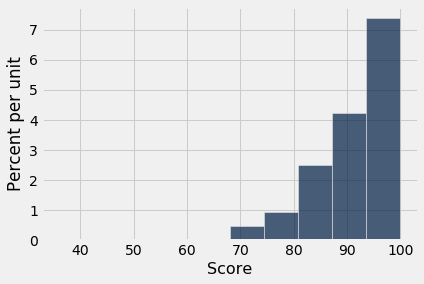

In [55]:
# Write your code here.
pop_restaurants.hist('Score')

This is the population mean:

In [56]:
pop_mean = np.mean(pop_restaurants.column(3))
pop_mean

91.40706693478886

Often it is impossible to find complete datasets like this.  Imagine we instead had access only to a random sample of 100 restaurants, called `restaurant_sample`.  That table is created below. We are interested in using this sample to estimate the population mean.

In [57]:
restaurant_sample = pop_restaurants.sample(100, with_replacement=False)
restaurant_sample

Restaurant Name,Zip Code,Inspection Date,Score,Address
"Children's Courtyard, The",78754,10/03/2016,97,"11012 HARRIS BRANCH PKWY AUSTIN, TX 78754 (30.344511, -9 ..."
El Agazajo Grill LLC,78744,10/08/2015,95,"2408 S US 183 HWY SB AUSTIN, TX 78744 (30.212947, -97.68 ..."
Mainspring Schools,78704,12/01/2015,89,"1100 W LIVE OAK ST AUSTIN, TX 78704 (30.246878, -97.76495)"
Summit Elementary,78727,09/01/2016,95,"12207 BRIGADOON LN AUSTIN, TX 78727 (30.418978, -97.719992)"
Springhill Suites,78759,12/14/2015,93,"10936 STONELAKE BLVD AUSTIN, TX 78759 (30.398647, -97.73 ..."
Lupitas Catering,78744,09/14/2015,100,"5107 S IH 35 SVRD NB AUSTIN, TX 78744 (30.203973, -97.75 ..."
MN - Manor High School Cafeteria,78653,05/12/2014,100,"12700 GREGG MANOR RD MANOR, TX 78653 (30.353147, -97.560927)"
Thundercloud Subs,78749,10/09/2015,94,"3601 W WILLIAM CANNON DR AUSTIN, TX 78749 (30.214384, -9 ..."
Wingzup,78751,01/09/2015,94,"1000 E 41ST ST Unit 210 AUSTIN, TX 78751 (30.298553, -97 ..."
Con'olio Oils & Vinegars,78759,07/24/2014,100,"10000 RESEARCH BLVD SB Unit 130 AUSTIN, TX 78759 (30.392 ..."


#### Question 2 (Ungraded)
Plot a histogram of the **sample** scores. 

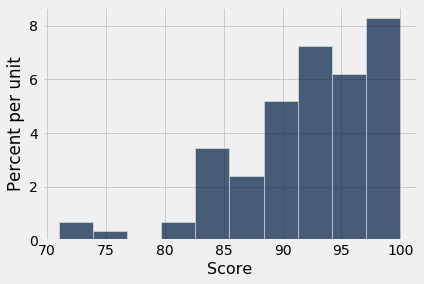

In [58]:
# Write your code here:
restaurant_sample.hist('Score')

This is the **sample mean**:

In [59]:
sample_mean = np.mean(restaurant_sample.column(3))
sample_mean

92.48

#### Question 3
Complete the function `bootstrap_scores` below. It should take no arguments. It should simulate drawing 5000 resamples from `restaurant_sample` and computing the mean restaurant score in each resample.  It should return an array of those 5000 resample means.

In [62]:
def bootstrap_scores():
    resampled_means = make_array()
    for i in range(5000):
        resampled_mean = np.mean(restaurant_sample.sample().column('Score'))
        resampled_means = np.append(resampled_means, resampled_mean)
    return resampled_means

resampled_means = bootstrap_scores()
resampled_means

array([91.93, 93.82, 92.56, ..., 92.97, 91.97, 92.81])

In [63]:
_ = ok.grade('q4_3')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Take a look at the histogram of the **resampled means**.

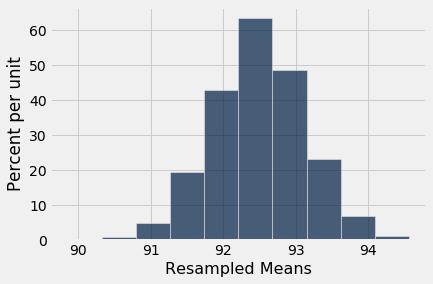

In [64]:
Table().with_column('Resampled Means',resampled_means).hist()

#### Question 4
Compute a 95 percent confidence interval for the average restaurant score.

In [65]:
lower_bound = percentile(2.5, resampled_means)
upper_bound = percentile(97.5, resampled_means)
print("95% confidence interval for the average restaurant score, computed by bootstrapping:\n(",lower_bound, ",", upper_bound, ")")

95% confidence interval for the average restaurant score, computed by bootstrapping:
( 91.22 , 93.72 )


#### Question 5
Does the distribution of the sampled scores look normally distributed? State "yes" or "no" and describe in one sentence why you should expect this result.

No the sampled scores do not look normally distributed. They have a left skew and are not bell shaped.

#### Question 6
Does the distribution of the resampled mean scores look normally distributed? State "yes" or "no" and describe in one sentence why you should expect this result.

Yes, it has a normal curve distribution with no left or right skews to it.

For the last question, you'll need to recall two facts.
1. If a group of numbers has a normal distribution, around 95% of them lie within 2 standard deviations of their mean.
2. The Central Limit Theorem tells us the quantitative relationship between
    * the standard deviation of an array of numbers and
    * the standard deviation of an array of means of samples taken from those numbers.

#### Question 7
Without referencing the array `resampled_means` or performing any new simulations, calculate an interval around the `sample_mean` that covers approximately 95% of the numbers in the `resampled_means` array.  **You may use the following values to compute your result, but you should not perform additional resampling.**

In [68]:
sample_mean = np.mean(restaurant_sample.column(3))
sample_sd = np.std(restaurant_sample.column(3))
resample_sizes = restaurant_sample.num_rows

lower_bound_normal = sample_mean -1.96 * sample_sd / np.sqrt(resample_sizes)
upper_bound_normal = sample_mean +1.96 * sample_sd / np.sqrt(resample_sizes)
print("95% confidence interval for the average restaurant score, computed by a normal approximation:\n(",lower_bound_normal, ",", upper_bound_normal, ")")

95% confidence interval for the average restaurant score, computed by a normal approximation:
( 91.23559910253971 , 93.7244008974603 )


This confidence interval should look very similar to the one you computed in question 5. If not, try calculating the inner 95 percent using 1.96 standard deviations instead of 2, for a more precise calculation. If they are still very different, there may be an error in your code.